In [1]:
from datetime import datetime, timedelta, timezone
from IPython.display import clear_output
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pyautogui
import math
import time

pd.options.display.float_format = '{:,.2f}'.format

# Download data

### Fetching tickers from nasdaq and filtering out ETFs and stocks that we have a problem getting their prices

In [2]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason

    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

In [3]:
def get_data(tickers_list, p="max"):
    return yf.download(tickers_list, period=p, interval="1d")

In [4]:
tickers = get_all_tickers()[:100]
# tickers = ["TSLA", "AAPL", "MSFT", "NVDA", "GOOG", "AACI"]
data = get_data(tickers)

[*********************100%%**********************]  100 of 100 completed


In [5]:
data_cop = data.copy()

In [6]:
new_df = pd.DataFrame(index=data_cop.index.year.unique(), columns=data_cop.columns)
new_df.drop("Adj Close", axis=1, level=0, inplace=True)
new_df["Volume"] = data_cop["Volume"].groupby(data_cop.index.year).mean()
new_df["Close"] = data_cop["Close"].groupby(data_cop.index.year).last()
new_df["Open"] = data_cop["Open"].groupby(data_cop.index.year).first()
new_df["High"] = data_cop["High"].groupby(data_cop.index.year).max()
new_df["Low"] = data_cop["Low"].groupby(data_cop.index.year).min()
for stock in new_df["Close"].columns:
    new_df["Change", stock] = np.nan
new_df["Change"] = new_df.xs("Close", axis=1, level=0).pct_change() * 100

C:\Users\sasso\AppData\Local\Temp\ipykernel_7052\1838130815.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Change", stock] = np.nan


In [7]:
stocks_checklist = pd.DataFrame(index=new_df["Close"].columns, columns=["Years up", "Div yield", "Sector", "avg daily vol", "Total Revenue Incr", "Gross Margin", "Gross Profit Incr", "Trading years"])

stocks_checklist

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
ACV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACXP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
stocks_checklist = pd.DataFrame(index=new_df["Close"].columns, columns=["Years up", "Div yield", "Sector", "avg daily vol", "Total Revenue Incr", "Gross Margin", "Gross Profit Incr", "Trading years"])

tickers = list(new_df["Close"].columns)  # In case some of the tickers failed, this is the ticker list straight from the returned df
# Years up in a row
tmp = new_df["Change"].copy().iloc[::-1]
tmp.fillna(-1, inplace=True)
neg_year = tmp.apply(lambda x: x[x < 0].index[0] if any(x<0) else None)
current_year = tmp.index[0]
stocks_checklist["Years up"] = current_year - neg_year.copy()
# stocks_checklist["Years up"] = 1
stocks_checklist["avg daily vol"] = new_df["Volume"].copy().iloc[-1:].mean()
stocks_checklist["avg daily vol"] = stocks_checklist["avg daily vol"].fillna(0)

# Eliminate by avg daily vol, so it'll be faster
stocks_checklist = stocks_checklist[stocks_checklist["avg daily vol"] > 40000]

# Div yield
print(f"0/{len(stocks_checklist.index)}")
i = 1
for ticker in stocks_checklist.index:
    clear_output(wait=True)
    print(ticker)
    print(f"{i}/{len(stocks_checklist.index)}")
    i += 1
    tmp = yf.Ticker(ticker)
    start_date = (datetime.now() - timedelta(days = 365))
    start_date = start_date.replace(tzinfo=timezone.utc)
    div_sum = tmp.dividends.loc[start_date:].sum()
    close_price = new_df["Close"][ticker].iloc[-1]
    div_yield = (div_sum/close_price) * 100
    stocks_checklist.loc[ticker, "Div yield"] = div_yield
    # Sector
    if "sector" in tmp.info:
        stocks_checklist.loc[ticker, "Sector"] = tmp.info["sector"]
    
    if "Gross Profit" in tmp.income_stmt.index:
        # Average Gross margin over the last 3 income statements
        if tmp.income_stmt.loc["Total Revenue"].all() > 0:
            stocks_checklist.loc[ticker, "Gross Margin"] = ((tmp.income_stmt.loc["Gross Profit"].iloc[::-1] / tmp.income_stmt.loc["Total Revenue"].iloc[::-1]) * 100).mean()  # Gross margin of the last 3 years
        
        # Gross profit increase percentage over the last 3 years (3 income statements)
        stocks_checklist.loc[ticker, "Gross Profit Incr"] = tmp.income_stmt.loc["Gross Profit"].iloc[::-1].pct_change().mean() * 100
    
    # Total Revenue increase percentage over the last 3 years (3 income statements)
    stocks_checklist.loc[ticker, "Total Revenue Incr"] = tmp.income_stmt.loc["Total Revenue"].iloc[::-1].pct_change().mean() * 100
    
    # How long the stock is trading for
    if "firstTradeDateEpochUtc" in tmp.info:
        tmp.info
        epoch = tmp.info["firstTradeDateEpochUtc"]
        if epoch > 0:
            fty = datetime.fromtimestamp(tmp.info["firstTradeDateEpochUtc"]).year  # First trade year
        else:
            fty = (datetime(1970, 1, 1) + timedelta(seconds=epoch)).year
        stocks_checklist.loc[ticker, "Trading years"] = current_year - fty
    
stocks_checklist["Div yield"].replace(0.0, np.nan, inplace=True)
stocks_checklist.replace([np.inf, -np.inf], np.nan, inplace=True)

ADAP
68/68


In [9]:
# stocks_checklist["avg daily vol"].fillna(0, inplace=True)
stocks_checklist

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years
A,0,0.70,Healthcare,"1,568,283.33",8.84,53.03,7.48,25.00
AA,0,1.50,Basic Materials,"6,748,525.00",16.66,18.95,51.19,62.00
AACIW,0,NaN,Financial Services,"62,645.00",NaN,NaN,NaN,NaN
AACT,1,NaN,Financial Services,"130,408.33",NaN,NaN,NaN,1.00
AADI,0,NaN,Healthcare,"477,350.00",664.37,95.61,"1,288.10",6.00
...,...,...,...,...,...,...,...,...
ACV,2,10.14,Financial Services,"41,841.67","-1,036.61",NaN,NaN,9.00
ACVA,0,NaN,Consumer Cyclical,"1,017,675.00",44.82,44.16,40.77,3.00
ACXP,1,NaN,Healthcare,"433,583.33",NaN,NaN,NaN,3.00
ADAG,2,NaN,Healthcare,"306,866.67",671.52,NaN,NaN,3.00


# Scoring

In [39]:
scores = pd.DataFrame(index=stocks_checklist.index, columns=stocks_checklist.columns)  # Generate scoring dataframe

### Dividend scoring

In [40]:
def div_func(x, peak1, peak2, med, sigma1, sigma2):
    f1 = (-1/(x*sigma1)) + peak2
    f2 = peak1 * np.exp(-((x-med)**2)/sigma2)
    return np.where(x < med, f2, f1)

In [41]:
peak1 = 6  # Y peak value of the first mishvaha
peak2 = 10  # Y peak value of the second mishvaha (the one where it shoef to)
starting_value = 0.4  # The score of a div yield 0

tmp = stocks_checklist["Div yield"].dropna()  # Drop no-dividend stocks
div_values = np.array(tmp.values)
div_stocks = np.array(tmp.index)
med = np.median(div_values)  # Median, to determine the peak of the first function
sigma1 = 1/(med*(peak2-peak1))  # In order for the second function to continue from where the first function stops (after the median point)
sigma2 = (med**2) / math.log(peak1/starting_value)  # Determine the slope by the starting point and peak of median
div_scores = div_func(div_values, peak1, peak2, med, sigma1, sigma2)

C:\Users\sasso\AppData\Local\Temp\ipykernel_7052\1739882789.py:2: RuntimeWarning: divide by zero encountered in divide
  f1 = (-1/(x*sigma1)) + peak2


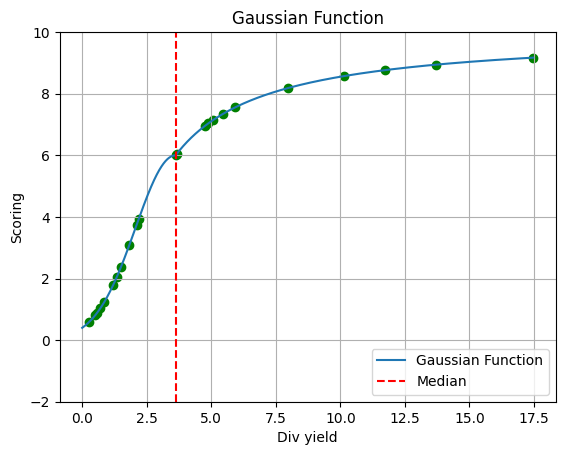

In [42]:
def plot_score(div_values, peak1, peak2, med, sigma1, sigma2):
    x_values = np.linspace(0, max(div_values), 5000)  # Generating 1000 values between 0 and 4
    y_values = div_func(x_values, peak1, peak2, med, sigma1, sigma2)
    # Calculate corresponding y values using the Gaussian function

    # Plot the function
    plt.plot(x_values, y_values, label=f'Gaussian Function')
    plt.ylim(-2, 10)  # Adjust these limits according to your needs

    plt.scatter(div_values, div_scores, color='green', marker='o')
    plt.axvline(med, color="red", linestyle="--", label="Median")
    plt.title('Gaussian Function')
    plt.xlabel('Div yield')
    plt.ylabel('Scoring')
    plt.legend()
    plt.grid(True)
plot_score(div_values, peak1, peak2, med, sigma1, sigma2)

In [43]:
scores.loc[div_stocks, "Div yield"] = div_scores
scores

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years
A,NaN,1.03,NaN,NaN,NaN,NaN,NaN,NaN
AA,NaN,2.36,NaN,NaN,NaN,NaN,NaN,NaN
AACIW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AADI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
ACV,NaN,8.57,NaN,NaN,NaN,NaN,NaN,NaN
ACVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACXP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Trading years score

In [44]:
def ty_func(values):
    # Linear
    max_years = max(values)
    f = values/(max_years/10)
    return f

In [45]:
ty_values = stocks_checklist["Trading years"]
ty_scores = ty_func(ty_values)
# ty_scores
scores["Trading years"] = ty_scores
scores

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years
A,NaN,1.03,NaN,NaN,NaN,NaN,NaN,4.03
AA,NaN,2.36,NaN,NaN,NaN,NaN,NaN,10.00
AACIW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16
AADI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97
...,...,...,...,...,...,...,...,...
ACV,NaN,8.57,NaN,NaN,NaN,NaN,NaN,1.45
ACVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48
ACXP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48
ADAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48


### Years up scoring

In [46]:
def yu_func(values):  # years up func
    f = (-1/(0.1 * values) + 10)

    return np.where(values == 0, 0, np.where(values == 1, 2, f))

In [47]:
yu_values = stocks_checklist["Years up"]
yu_scores = yu_func(yu_values)
scores["Years up"] = yu_scores

### Average daily volume & Total rev incrs scoring & Gross profit incr

In [48]:
def linear_max_func(values):  # Score 10 (max) determined by max value in values
    m = 10/max(values)
    f = m*values
    return f

In [49]:
scores["avg daily vol"] = linear_max_func(stocks_checklist["avg daily vol"])
scores["Total Revenue Incr"] = linear_max_func(stocks_checklist["Total Revenue Incr"])
# scores["Gross Profit Incr"] = linear_max_func(stocks_checklist["Gross Profit Incr"])

In [50]:
scores["Total"] = scores.sum(axis=1)
scores

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years,Total
A,0.00,1.03,NaN,0.27,0.13,NaN,NaN,4.03,5.46
AA,0.00,2.36,NaN,1.15,0.25,NaN,NaN,10.00,13.76
AACIW,0.00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,0.01
AACT,2.00,NaN,NaN,0.02,NaN,NaN,NaN,0.16,2.18
AADI,0.00,NaN,NaN,0.08,9.89,NaN,NaN,0.97,10.94
...,...,...,...,...,...,...,...,...,...
ACV,5.00,8.57,NaN,0.01,-15.44,NaN,NaN,1.45,-0.41
ACVA,0.00,NaN,NaN,0.17,0.67,NaN,NaN,0.48,1.32
ACXP,2.00,NaN,NaN,0.07,NaN,NaN,NaN,0.48,2.56
ADAG,5.00,NaN,NaN,0.05,10.00,NaN,NaN,0.48,15.54


In [51]:
yf.Ticker("AAL").incomestmt

,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,"-61,220,430.11","872,578,492.94","147,313,018.42"
Tax Rate For Calcs,0.32,0.22,0.22
Normalized EBITDA,"4,639,000,000.00","-2,419,000,000.00","-8,513,000,000.00"
Total Unusual Items,"-193,000,000.00","4,006,000,000.00","657,000,000.00"
Total Unusual Items Excluding Goodwill,"-193,000,000.00","4,006,000,000.00","657,000,000.00"
Net Income From Continuing Operation Net Minority Interest,"127,000,000.00","-1,993,000,000.00","-8,885,000,000.00"
Reconciled Depreciation,"2,298,000,000.00","2,335,000,000.00","2,370,000,000.00"
Reconciled Cost Of Revenue,"39,934,000,000.00","29,855,000,000.00","24,563,000,000.00"
EBITDA,"4,446,000,000.00","1,587,000,000.00","-7,856,000,000.00"
EBIT,"2,148,000,000.00","-748,000,000.00","-10,226,000,000.00"


In [52]:
def gross_incr_func(values, low, high, angle):
    high += 5
    w = 0 - math.tan(-(low*math.pi)/high - (math.pi/2))
    print(w)
    print(high)
    # f = 15*(np.arctan(values - w)/math.pi) + 2.5
    f = (high * (np.arctan(angle*values-w) + (math.pi/2)) / math.pi) + low

    return f

In [53]:
tmp = stocks_checklist["Gross Profit Incr"].dropna()
med = np.median(tmp)
# peak1 = 6  # Y peak value of the first mishvaha
# peak2 = 10  # Y peak value of the second mishvaha (the one where it shoef to)
# starting_value = 0.4  # The score of a div yield 0
low = -5
high = 10
sigma = 0.05
gross_scores = gross_incr_func(tmp, low, high, sigma)
scores["Gross Profit Incr"] = gross_scores
# plot_score(vals, 8, 0, np.median(vals), sigma1, sigma2)
# vals
# med

0.5773502691896258
15


0.5773502691896258
15
0.5773502691896258
15


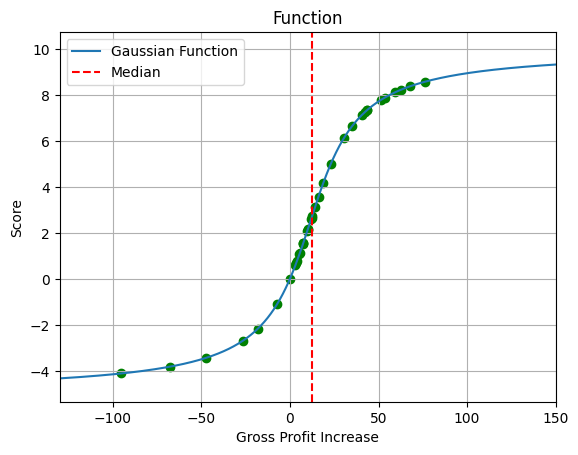

In [54]:
x_values = np.linspace(-130, 150, 5000)  # Generating 1000 values between 0 and 4
gross_scores = gross_incr_func(tmp, low, high, sigma)
y_values = gross_incr_func(x_values, low, high, sigma)
# Calculate corresponding y values using the Gaussian function

# Plot the function
plt.plot(x_values, y_values, label=f'Gaussian Function')
# plt.ylim(-2, 10)  # Adjust these limits according to your needs
plt.xlim(-130, 150)
plt.scatter(tmp, gross_scores, color='green', marker='o')
plt.axvline(med, color="red", linestyle="--", label="Median")
plt.title('Function')
plt.xlabel('Gross Profit Increase')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
# plot_score(div_values, peak1, peak2, med, sigma1, sigma2)

In [55]:
scores

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years,Total
A,0.00,1.03,NaN,0.27,0.13,NaN,1.54,4.03,5.46
AA,0.00,2.36,NaN,1.15,0.25,NaN,7.77,10.00,13.76
AACIW,0.00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,0.01
AACT,2.00,NaN,NaN,0.02,NaN,NaN,NaN,0.16,2.18
AADI,0.00,NaN,NaN,0.08,9.89,NaN,9.93,0.97,10.94
...,...,...,...,...,...,...,...,...,...
ACV,5.00,8.57,NaN,0.01,-15.44,NaN,NaN,1.45,-0.41
ACVA,0.00,NaN,NaN,0.17,0.67,NaN,7.13,0.48,1.32
ACXP,2.00,NaN,NaN,0.07,NaN,NaN,NaN,0.48,2.56
ADAG,5.00,NaN,NaN,0.05,10.00,NaN,NaN,0.48,15.54
